In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cfp
import scanpy as sc
import numpy as np
import functools
from ott.solvers import utils as solver_utils
import optax

In [3]:
adata_train = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_train_biolord_split.h5ad")
adata_test = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_test_biolord_split.h5ad")
adata_ood = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_ood_biolord_split.h5ad")

In [4]:
adata_train.obs["CTRL"] = adata_train.obs.apply(lambda x: True if x["drug"] == "Vehicle" else False, axis=1)
adata_test.obs["CTRL"] = adata_test.obs.apply(lambda x: True if x["drug"] == "Vehicle" else False, axis=1)
adata_ood.obs["CTRL"] = adata_ood.obs.apply(lambda x: True if x["drug"] == "Vehicle" else False, axis=1)

In [5]:
adata_tmp =  adata_train[adata_train.obs["drug"].drop_duplicates().index]
ecfp_dict = {drug: adata_tmp[adata_tmp.obs["drug"]==drug].obsm["ecfp"] for drug in adata_tmp.obs["drug"]}

adata_tmp =  adata_ood[adata_ood.obs["drug"].drop_duplicates().index]
ecfp_dict.update({drug: adata_tmp[adata_tmp.obs["drug"]==drug].obsm["ecfp"] for drug in adata_tmp.obs["drug"]})

adata_tmp =  adata_ood[adata_ood.obs["cell_line"].drop_duplicates().index]
cell_line_dict = {cell_line: adata_tmp[adata_tmp.obs["cell_line"]==cell_line].obsm["cell_line_emb"] for cell_line in adata_tmp.obs["cell_line"]}

In [6]:
adata_train.uns['ecfp_rep'] = ecfp_dict
adata_test.uns['ecfp_rep'] = ecfp_dict
adata_ood.uns['ecfp_rep'] = ecfp_dict
adata_train.uns['cl_rep'] = cell_line_dict
adata_test.uns['cl_rep'] = cell_line_dict
adata_ood.uns['cl_rep'] = cell_line_dict

In [7]:
prepare_config = {
    "sample_rep": "X_pca",
    "perturbation_covariates": {"drugs": ["drug"],
        "dose": ["logdose"],},
    "perturbation_covariate_reps": {
        "drugs": "ecfp_rep",
    },
    "sample_covariates": [],#["cell_line"],
    "sample_covariate_reps": {},
    #    "cell_line": "cl_rep",
    #}, # or both sample_covaraites and sample_covariate_reps None,
    "split_covariates": ["cell_line"], 
}

In [8]:
# Initialize CellFlow
cf = cfp.model.CellFlow(adata_train, solver="otfm")

# Prepare the training data and perturbation conditions
cf.prepare_data(
    sample_rep=prepare_config["sample_rep"],
    control_key="CTRL",
    perturbation_covariates=prepare_config["perturbation_covariates"],
    perturbation_covariate_reps=prepare_config["perturbation_covariate_reps"],
    sample_covariates=prepare_config["sample_covariates"],
    sample_covariate_reps=prepare_config["sample_covariate_reps"],
    split_covariates=prepare_config["split_covariates"],
)







/ictstr01/home/icb/dominik.klein/git_repos/cell_flow_perturbation/src/cfp/data/_datamanager.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
2024-08-22 16:31:59.109187: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
100%|██████████| 670/670 [00:08<00:00, 75.68it/s]


In [9]:
model_config = {
    "condition_embedding_dim" : 1024,
    "time_encoder_dims": (1024, 1024, 1024),
    "time_encoder_dropout": 0.0,
    "hidden_dims": (2048, 2048, 2048),
    "hidden_dropout": 0.2,
    "decoder_dims": (1024, 1024, 1024),
    "decoder_dropout": 0.0,
    "pooling": "mean",
    "layers_before_pool": {"drugs": ({"layer_type": "mlp", "dims": (1024, 1024, 512)}),
                           "dose": ({"layer_type": "mlp", "dims": (128, 256, 512)}),
                          #"cell_line": ({"layer_type": "mlp", "dims": (512, 512)})},
                          },
    "layers_after_pool": {"layer_type": "mlp", "dims": (1024, 1024)},
    "cond_output_dropout": 0.9,
    "time_freqs": 1024,
    "epsilon": 0.1,
    "tau_a": 0.99,
    "tau_b": 0.99,
    "learning_rate": 1e-4,
    "multisteps": 50,
    "flow_type": "constant_noise",
    "flow_noise": 1.0,
}

In [10]:
match_fn = functools.partial(solver_utils.match_linear, epsilon=model_config["epsilon"], scale_cost="mean", tau_a=model_config["tau_a"], tau_b=model_config["tau_b"])
optimizer = optax.MultiSteps(optax.adam(model_config["learning_rate"]), model_config["multisteps"])
flow = {model_config["flow_type"]: model_config["flow_noise"]}

# Prepare the model
cf.prepare_model(
    encode_conditions=True,
    condition_embedding_dim=model_config["condition_embedding_dim"],
    time_encoder_dims = model_config["time_encoder_dims"],
    time_encoder_dropout = model_config["time_encoder_dropout"],
    hidden_dims=model_config["hidden_dims"],
    hidden_dropout = model_config["hidden_dropout"],
    decoder_dims=model_config["decoder_dims"],
    decoder_dropout=model_config["decoder_dropout"],
    pooling=model_config["pooling"],
    layers_before_pool=model_config["layers_before_pool"],
    layers_after_pool=model_config["layers_after_pool"],
    cond_output_dropout=model_config["cond_output_dropout"],
    time_freqs = model_config["time_freqs"],
    match_fn=match_fn,
    optimizer=optimizer,
    flow=flow,
)



In [11]:
cf.prepare_validation_data(adata_test, name="test", 
        n_conditions_on_log_iteration= 3,
        n_conditions_on_train_end=3)

cf.prepare_validation_data(adata_ood, name="ood", 
        n_conditions_on_log_iteration=None,
        n_conditions_on_train_end=None)

In [12]:
from typing import NamedTuple, Any

class PCADecoder(NamedTuple):
    pcs: Any
    means: Any

pca_dec = PCADecoder(adata_train.varm["PCs"], adata_train.varm["X_train_mean"])

In [13]:
metrics_callback = cfp.training.Metrics(metrics=["r_squared", "mmd", "e_distance"])
decoded_metrics_callback = cfp.training.PCADecodedMetrics(pca_decoder=pca_dec, metrics=["r_squared", "mmd", "e_distance"])
wandb_callback = cfp.training.WandbLogger(project="cfp", out_dir="/home/icb/dominik.klein/tmp", config={})


callbacks =[]# [metrics_callback, decoded_metrics_callback]#, wandb_callback]

In [14]:
training_config = {
    "num_iterations": 1_000,
    "batch_size": 1024,
    "valid_freq": 100_000,
}

In [15]:
# Train the model
cf.train(
    num_iterations=training_config["num_iterations"],
    batch_size=training_config["batch_size"],
    callbacks=callbacks,
    valid_freq=training_config["valid_freq"],
)

100%|██████████| 1000/1000 [01:19<00:00, 12.62it/s]


In [18]:
cf.trainer.training_logs.keys()

dict_keys(['loss', 'test_r_squared_mean', 'ood_r_squared_mean', 'test_mmd_mean', 'ood_mmd_mean', 'test_e_distance_mean', 'ood_e_distance_mean', 'pca_decoded_ood_r_squared_mean', 'pca_decoded_test_r_squared_mean', 'pca_decoded_ood_mmd_mean', 'pca_decoded_test_mmd_mean', 'pca_decoded_ood_e_distance_mean', 'pca_decoded_test_e_distance_mean'])

In [17]:
cf.trainer.training_logs['pca_decoded_test_r_squared_mean'], cf.trainer.training_logs['pca_decoded_ood_r_squared_mean']

([0.9906630159844672], [0.7265711921632052])

In [1]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(cf.trainer.training_logs['loss'])), cf.trainer.training_logs['loss'])

NameError: name 'np' is not defined

In [19]:
conditions = adata_test.obs.drop_duplicates(subset=["drug", "logdose"])

In [20]:
cond_emb = cf.get_condition_embedding(conditions, rep_dict=adata_test.uns)

/ictstr01/home/icb/dominik.klein/git_repos/cell_flow_perturbation/src/cfp/data/_datamanager.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 670/670 [00:00<00:00, 1063.29it/s]


In [23]:
cond_emb#.drop_duplicates()

0         1         2     \
drugs                               dose                                 
Raltitrexed                         1.0   0.286038  0.287331  0.429151   
Vehicle                             0.0  -0.003393 -0.003829 -0.002568   
Lenalidomide_(CC-5013)              1.0   0.188351  0.697865  0.155767   
Linifanib_(ABT-869)                 2.0   0.139318 -0.094316  0.287690   
                                    4.0   0.143142 -0.076612  0.210952   
...                                            ...       ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0   0.105571  0.248427  0.358411   
Fedratinib_(SAR302503,_TG101348)    2.0   0.036489 -1.002094  0.420340   
Fulvestrant                         1.0   0.842258  0.560490  0.766575   
Resminostat                         4.0  -0.188691 -0.038017  0.253769   
Alendronate_sodium_trihydrate       2.0   0.108997  0.143749  0.347408   

                                              3         4         5     \
drugs                               dose                                 
Raltitrexed                         1.0  -0.617014  0.764500  0.091455   
Vehicle                             0.0   0.000089  0.002279  0.001963   
Lenalidomide_(CC-5013)              1.0  -0.450926  0.598639  0.294823   
Linifanib_(ABT-869)                 2.0  -0.861763  1.025015 -0.209889   
                                    4.0  -0.851137  0.995037 -0.263366   
...                                            ...       ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0  -0.388204  0.123639  0.592313   
Fedratinib_(SAR302503,_TG101348)    2.0  -0.395091  0.241750  0.183664   
Fulvestrant                         1.0  -1.550213  0.680097  0.648602   
Resminostat                         4.0  -0.341443  0.866953  0.199496   
Alendronate_sodium_trihydrate       2.0  -0.491791  0.202942 -0.089254   

                                              6         7         8     \
drugs                               dose                                 
Raltitrexed                         1.0   0.465767 -0.058417  0.336467   
Vehicle                             0.0   0.001634  0.001671 -0.003659   
Lenalidomide_(CC-5013)              1.0   0.122589 -0.161862 -0.171492   
Linifanib_(ABT-869)                 2.0   0.221150  0.129804 -0.687739   
                                    4.0   0.238776  0.118876 -0.755713   
...                                            ...       ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0  -0.127973 -0.301831 -0.780811   
Fedratinib_(SAR302503,_TG101348)    2.0   0.175704 -0.448280 -0.559151   
Fulvestrant                         1.0   1.118303  0.416023  0.159632   
Resminostat                         4.0   0.318867 -0.594559  0.157219   
Alendronate_sodium_trihydrate       2.0   0.037535  0.377112  0.205608   

                                              9     ...      1014      1015  \
drugs                               dose            ...                       
Raltitrexed                         1.0  -0.191688  ... -0.208791  0.611874   
Vehicle                             0.0   0.002458  ... -0.001561 -0.000957   
Lenalidomide_(CC-5013)              1.0  -0.071050  ... -0.402003 -0.315611   
Linifanib_(ABT-869)                 2.0   0.104461  ... -0.202377  0.027881   
                                    4.0   0.128097  ... -0.285101 -0.017126   
...                                            ...  ...       ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0   0.106821  ... -0.501106  0.403060   
Fedratinib_(SAR302503,_TG101348)    2.0   0.335510  ... -0.399145  0.096397   
Fulvestrant                         1.0   1.956576  ...  0.773102 -0.592549   
Resminostat                         4.0   0.149434  ... -0.416813  0.103524   
Alendronate_sodium_trihydrate       2.0   0.213042  ...  0.434370  0.067523   

                                              1016      1017      1018  \
drugs                               dose               

In [25]:
from cfp.plotting import plot_embeddings

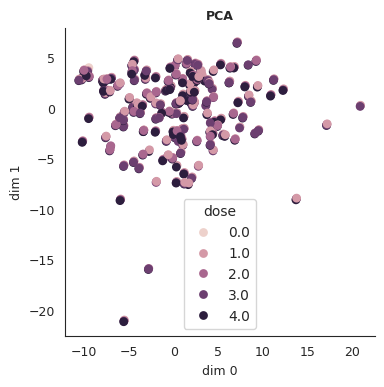

In [95]:
out = plot_embeddings(cf.adata, embedding="PCA", components=(0,1), hue="dose")

In [88]:
dff = pd.DataFrame(data=cond_emb.values, columns=list(range(1024)), index=cond_emb.index)

In [87]:
cond_emb.valu

0         1         2     \
drugs                               dose                                 
Raltitrexed                         1.0   0.286038  0.287331  0.429151   
Vehicle                             0.0  -0.003393 -0.003829 -0.002568   
Lenalidomide_(CC-5013)              1.0   0.188351  0.697865  0.155767   
Linifanib_(ABT-869)                 2.0   0.139318 -0.094316  0.287690   
                                    4.0   0.143142 -0.076612  0.210952   
...                                            ...       ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0   0.105571  0.248427  0.358411   
Fedratinib_(SAR302503,_TG101348)    2.0   0.036489 -1.002094  0.420340   
Fulvestrant                         1.0   0.842258  0.560490  0.766575   
Resminostat                         4.0  -0.188691 -0.038017  0.253769   
Alendronate_sodium_trihydrate       2.0   0.108997  0.143749  0.347408   

                                              3         4         5     \
drugs                               dose                                 
Raltitrexed                         1.0  -0.617014  0.764500  0.091455   
Vehicle                             0.0   0.000089  0.002279  0.001963   
Lenalidomide_(CC-5013)              1.0  -0.450926  0.598639  0.294823   
Linifanib_(ABT-869)                 2.0  -0.861763  1.025015 -0.209889   
                                    4.0  -0.851137  0.995037 -0.263366   
...                                            ...       ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0  -0.388204  0.123639  0.592313   
Fedratinib_(SAR302503,_TG101348)    2.0  -0.395091  0.241750  0.183664   
Fulvestrant                         1.0  -1.550213  0.680097  0.648602   
Resminostat                         4.0  -0.341443  0.866953  0.199496   
Alendronate_sodium_trihydrate       2.0  -0.491791  0.202942 -0.089254   

                                              6         7         8     \
drugs                               dose                                 
Raltitrexed                         1.0   0.465767 -0.058417  0.336467   
Vehicle                             0.0   0.001634  0.001671 -0.003659   
Lenalidomide_(CC-5013)              1.0   0.122589 -0.161862 -0.171492   
Linifanib_(ABT-869)                 2.0   0.221150  0.129804 -0.687739   
                                    4.0   0.238776  0.118876 -0.755713   
...                                            ...       ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0  -0.127973 -0.301831 -0.780811   
Fedratinib_(SAR302503,_TG101348)    2.0   0.175704 -0.448280 -0.559151   
Fulvestrant                         1.0   1.118303  0.416023  0.159632   
Resminostat                         4.0   0.318867 -0.594559  0.157219   
Alendronate_sodium_trihydrate       2.0   0.037535  0.377112  0.205608   

                                              9     ...      1014      1015  \
drugs                               dose            ...                       
Raltitrexed                         1.0  -0.191688  ... -0.208791  0.611874   
Vehicle                             0.0   0.002458  ... -0.001561 -0.000957   
Lenalidomide_(CC-5013)              1.0  -0.071050  ... -0.402003 -0.315611   
Linifanib_(ABT-869)                 2.0   0.104461  ... -0.202377  0.027881   
                                    4.0   0.128097  ... -0.285101 -0.017126   
...                                            ...  ...       ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0   0.106821  ... -0.501106  0.403060   
Fedratinib_(SAR302503,_TG101348)    2.0   0.335510  ... -0.399145  0.096397   
Fulvestrant                         1.0   1.956576  ...  0.773102 -0.592549   
Resminostat                         4.0   0.149434  ... -0.416813  0.103524   
Alendronate_sodium_trihydrate       2.0   0.213042  ...  0.434370  0.067523   

                                              1016      1017      1018  \
drugs                               dose               

In [83]:
import pandas as pd
df = pd.DataFrame({
    'Category': ['A', 'A', 'B', 'B'],
    'Subcategory': [1, 2, 1, 2],
    'Values': [10, 20, 30, 40]
})

<Axes: xlabel='Subcategory', ylabel='Values'>

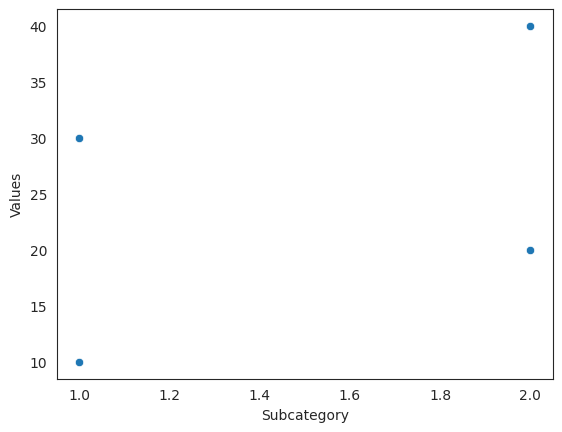

In [84]:
sns.scatterplot(
        data=df,
        x="Subcategory",
        y="Values",
    )

<Axes: xlabel='0', ylabel='1'>

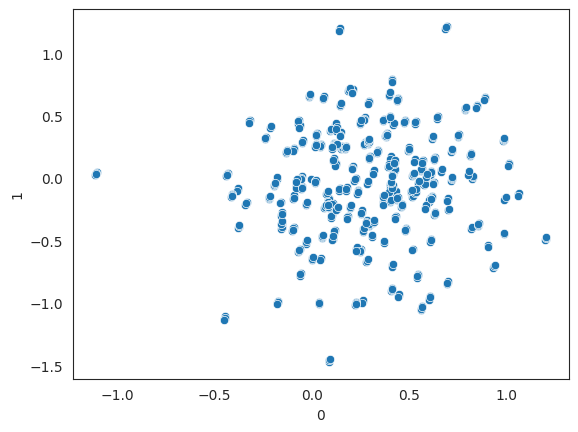

In [89]:
import seaborn as sns
sns.scatterplot(
        data=dff,
        x=0,
        y=1,
    )

In [79]:
out["0"]= np.squeeze(out[0].values)
out["1"]= np.squeeze(out[1].values)

In [33]:
cond_emb.keys()

dict_keys([('Raltitrexed', 1.0), ('Vehicle', 0.0), ('Lenalidomide_(CC-5013)', 1.0), ('Linifanib_(ABT-869)', 2.0), ('Linifanib_(ABT-869)', 4.0), ('S3I-201', 1.0), ('Nintedanib_(BIBF_1120)', 2.0), ('Avagacestat_(BMS-708163)', 2.0), ('IOX2', 4.0), ('Regorafenib_(BAY_73-4506)', 2.0), ('Sodium_Phenylbutyrate', 1.0), ('NVP-BSK805_2HCl', 2.0), ('Veliparib_(ABT-888)', 3.0), ('Maraviroc', 4.0), ('Bosutinib_(SKI-606)', 2.0), ('JNJ-26854165_(Serdemetan)', 2.0), ('TGX-221', 4.0), ('Mesna_', 1.0), ('GSK-LSD1_2HCl', 2.0), ('Droxinostat', 1.0), ('Mesna_', 2.0), ('Celecoxib', 1.0), ('M344', 1.0), ('TGX-221', 3.0), ('Gandotinib_(LY2784544)', 2.0), ('Obatoclax_Mesylate_(GX15-070)', 2.0), ('Capecitabine_', 1.0), ('Toremifene_Citrate', 1.0), ('AR-42', 2.0), ('MC1568', 3.0), ('INO-1001_(3-Aminobenzamide)', 2.0), ('Streptozotocin_(STZ)', 3.0), ('Tacedinaline_(CI994)', 1.0), ('Altretamine', 2.0), ('GSK_J1', 4.0), ('Lapatinib_(GW-572016)_Ditosylate', 2.0), ('AC480_(BMS-599626)', 4.0), ('Resminostat', 1.0), ('

In [40]:
import pandas as pd
df_emb = pd.DataFrame.from_dict({k: v[0] for k,v in cond_emb.items()}).T

In [42]:
set_plotting_vars(
                cf.adata, key="my_key", value=df_emb
            )

In [46]:
#cf.adata.uns['cell_flow_perturbation']


In [64]:
from collections.abc import Sequence
from typing import Any

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import cosine_similarity

from cfp import _constants, _logging
from cfp.model import CellFlow


def set_plotting_vars(
    adata: ad.AnnData,
    *,
    key: str,
    value: Any,
    override: bool = True,
) -> None:
    uns_key = _constants.CFP_KEY
    adata.uns.setdefault(uns_key, {})
    if not override and key in adata.uns[uns_key]:
        raise KeyError(
            f"Data in `adata.uns[{uns_key!r}][{key!r}]` "
            f"already exists, use `override=True`."
        )
    adata.uns[uns_key][key] = value


def _get_palette(
    n_colors: int, palette_name: str | None = "Set1"
) -> sns.palettes._ColorPalette:
    try:
        palette = sns.color_palette(palette_name)
    except ValueError:
        _logging.logger.info("Palette not found. Using default palette tab10")
        palette = sns.color_palette()
    while len(palette) < n_colors:
        palette += palette

    return palette


def _get_colors(
    labels: Sequence[str],
    palette: str | None = None,
    palette_name: str | None = None,
) -> dict[str, str]:
    n_colors = len(labels)
    if palette is None:
        palette = _get_palette(n_colors, palette_name)
    col_dict = dict(zip(labels, palette[:n_colors], strict=False))
    return col_dict


def get_plotting_vars(adata: ad.AnnData, *, key: str) -> Any:
    uns_key = _constants.CFP_KEY
    try:
        return adata.uns[uns_key][key]
    except KeyError:
        raise KeyError(f"No data found in `adata.uns[{uns_key!r}][{key!r}]`.") from None


def _input_to_adata(obj: ad.AnnData | CellFlow) -> ad.AnnData:
    if isinstance(obj, ad.AnnData):
        return obj
    elif isinstance(obj, CellFlow):
        return obj.adata
    else:
        raise ValueError(
            f"obj must be an AnnData or CellFlow object, but found {type(obj)}"
        )


def _compute_umap_from_df(
    df: pd.DataFrame,
    n_neighbors: int = 15,
    n_pcs: int = 50,
    n_components: int = 2,
    **kwargs,
) -> pd.DataFrame:
    adata_tmp = ad.AnnData(df.values)
    if adata_tmp.n_vars > n_pcs:
        sc.pp.pca(adata_tmp, n_comps=n_pcs)
    sc.pp.neighbors(adata_tmp, n_neighbors=n_neighbors)
    sc.tl.umap(adata_tmp, n_components=n_components, **kwargs)

    return pd.DataFrame(
        data=adata_tmp.obsm["X_umap"],
        columns=[i for i in range(n_components)],
        index=df.index,
    )


def _compute_pca_from_df(df: pd.DataFrame, n_components: int = 30) -> pd.DataFrame:
    adata_tmp = ad.AnnData(df.values)
    sc.pp.pca(adata_tmp, n_comps=n_components)
    return pd.DataFrame(
        data=adata_tmp.obsm["X_pca"],
        columns=[i for i in range(adata_tmp.obsm["X_pca"].shape[1])],
        index=df.index,
    )


def _compute_kernel_pca_from_df(
    df: pd.DataFrame, n_components: int = 30, **kwargs
) -> pd.DataFrame:
    similarity_matrix = cosine_similarity(df.values)
    np.fill_diagonal(similarity_matrix, 1.0)
    X = KernelPCA(n_components=n_components, kernel="precomputed").fit_transform(
        similarity_matrix
    )
    return pd.DataFrame(
        data=X, columns=[i for i in range(n_components)], index=df.index
    )


In [69]:
def plot_embeddings(
    obj: ad.AnnData | CellFlow,
    embedding: Literal["raw_embedding", "UMAP", "PCA", "Kernel_PCA"],
    dimensions: tuple[int, int] = (0, 1),
    key: str = CONDITION_EMBEDDING,
    labels: list[str] = None,
    col_dict: dict[str, str] | None = None,
    title: str | None = None,
    show_lines: bool = False,
    show_text: bool = False,
    return_fig: bool = True,
    **kwargs: Any,
) -> mpl.figure.Figure:
    adata = _input_to_adata(obj)
    df = get_plotting_vars(adata, key=key)
    if embedding == "raw_embedding":
        emb = df[list(dimensions)]
    elif embedding == "UMAP":
        emb = _compute_umap_from_df(df)
    elif embedding == "PCA":
        emb = _compute_pca_from_df(df)
    elif embedding == "Kernel_PCA":
        emb = _compute_kernel_pca_from_df(df)
    else:
        raise ValueError(f"Embedding {embedding} not supported.")

    circle_size = kwargs.pop("circle_size", 40)
    circe_transparency = kwargs.pop("circe_transparency", 1.0)
    line_transparency = kwargs.pop("line_transparency", 0.8)
    line_width = kwargs.pop("line_width", 1.0)
    fontsize = kwargs.pop("fontsize", 9)
    fig_width = kwargs.pop("fig_width", 4)
    fig_height = kwargs.pop("fig_height", 4)
    labels_name = kwargs.pop("labels_name", None)
    axis_equal = kwargs.pop("axis_equal", None)

    sns.set_style("white")

    if labels is not None:
        if labels_name is None:
            labels_name = "labels"
        emb[labels_name] = labels

    fig = plt.figure(figsize=(fig_width, fig_height))
    ax = plt.gca()

    sns.despine(left=False, bottom=False, right=True)

    if (col_dict is None) and labels is not None:
        col_dict = _get_colors(labels)

    
    sns.scatterplot(
        data=emb,
        x=dimensions[0],
        y=dimensions[1],
        hue=labels_name,
        palette=col_dict,
        alpha=circe_transparency,
        edgecolor="none",
        s=circle_size,
        ax=ax,
    )

    if show_lines:
        for i in range(len(emb)):
            if col_dict is None:
                ax.plot(
                    [0, emb[i, 0]],
                    [0, emb[i, 1]],
                    alpha=line_transparency,
                    linewidth=line_width,
                    c=None,
                )
            else:
                ax.plot(
                    [0, emb[i, 0]],
                    [0, emb[i, 1]],
                    alpha=line_transparency,
                    linewidth=line_width,
                    c=col_dict[labels[i]],
                )

    if show_text and labels is not None:
        texts = []
        labels = np.array(labels)
        unique_labels = np.unique(labels)
        for label in unique_labels:
            idx_label = np.where(labels == label)[0]
            texts.append(
                ax.text(
                    np.mean(emb[idx_label, 0]),
                    np.mean(emb[idx_label, 1]),
                    label,
                    fontsize=fontsize,
                )
            )

        adjust_text(
            texts,
            arrowprops=dict(arrowstyle="-", color="black", lw=0.1),  # noqa: C408
            ax=ax,
        )

    if axis_equal:
        ax.axis("equal")
        ax.axis("square")

    title = title if title else embedding
    ax.set_title(title, fontsize=fontsize, fontweight="bold")
    

    ax.set_xlabel(f"dim {dimensions[0]}", fontsize=fontsize)
    ax.set_ylabel(f"dim {dimensions[1]}", fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)

    return fig if return_fig else None


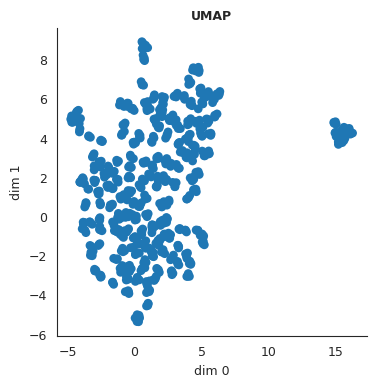

In [75]:
_ = plot_embeddings(cf, key="my_key", embedding="UMAP", dimensions = (0,1), show_text=True)

drugs  \
drugs                               dose                                        
Raltitrexed                         1.0                           Raltitrexed   
Vehicle                             0.0                               Vehicle   
Lenalidomide_(CC-5013)              1.0                Lenalidomide_(CC-5013)   
Linifanib_(ABT-869)                 2.0                   Linifanib_(ABT-869)   
                                    4.0                   Linifanib_(ABT-869)   
...                                                                       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0   Baricitinib_(LY3009104,_INCB028050)   
Fedratinib_(SAR302503,_TG101348)    2.0      Fedratinib_(SAR302503,_TG101348)   
Fulvestrant                         1.0                           Fulvestrant   
Resminostat                         4.0                           Resminostat   
Alendronate_sodium_trihydrate       2.0         Alendronate_sodium_trihydrate   

                                          dose         0         1         2  \
drugs                               dose                                       
Raltitrexed                         1.0    1.0  0.365733 -0.313410  0.112259   
Vehicle                             0.0    0.0 -0.009352 -0.012112 -0.007528   
Lenalidomide_(CC-5013)              1.0    1.0  0.228327  0.499575  0.026159   
Linifanib_(ABT-869)                 2.0    2.0  0.232821 -0.441883  0.079070   
                                    4.0    4.0  0.232676 -0.427730 -0.007480   
...                                        ...       ...       ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0    3.0  0.098704 -0.134626  0.013859   
Fedratinib_(SAR302503,_TG101348)    2.0    2.0  0.075869 -1.429120  0.087231   
Fulvestrant                         1.0    1.0  1.099778 -0.054216  0.272702   
Resminostat                         4.0    4.0 -0.137175 -0.267369 -0.018353   
Alendronate_sodium_trihydrate       2.0    2.0  0.218795 -0.046852  0.189446   

                                                 3         4         5  \
drugs                               dose                                 
Raltitrexed                         1.0  -1.337495  1.383217  0.464194   
Vehicle                             0.0   0.002735  0.000759  0.007097   
Lenalidomide_(CC-5013)              1.0  -0.746298  0.822615  0.505734   
Linifanib_(ABT-869)                 2.0  -1.463255  1.430283  0.063568   
                                    4.0  -1.454123  1.419675 -0.002084   
...                                            ...       ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0  -0.920548  0.668540  0.888878   
Fedratinib_(SAR302503,_TG101348)    2.0  -1.174175  0.842843  0.446647   
Fulvestrant                         1.0  -2.460662  1.634295  1.033522   
Resminostat                         4.0  -0.813688  1.223555  0.472787   
Alendronate_sodium_trihydrate       2.0  -0.723836  0.451434  0.044326   

                                                 6         7  ...      1014  \
drugs                               dose                      ...             
Raltitrexed                         1.0   0.227006 -0.155897  ... -0.474300   
Vehicle                             0.0   0.000243  0.007776  ... -0.003475   
Lenalidomide_(CC-5013)              1.0   0.055097 -0.157749  ... -0.532189   
Linifanib_(ABT-869)                 2.0   0.099007 -0.051762  ... -0.404868   
                                    4.0   0.123777 -0.076292  ... -0.494809   
...                                            ...       ...  ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0  -0.377093 -0.536925  ... -0.757116   
Fedratinib_(SAR302503,_TG101348)    2.0   0.154828 -0.701220  ... -0.699938   
Fulvestrant                         1.0   0.783019  0.061091  ...  0.447523   
Resminostat                         4.0   0.219637 -0.810286  ... -0.645069   
Alendronate_sodium_trihydrate       2.0  -0.177233  0.223995  ... 

In [83]:
cdata = cf.dm.get_condition_data(adata_test.obs.drop_duplicates(subset=["drug", "logdose"]), rep_dict=adata_test.uns)

/ictstr01/home/icb/dominik.klein/git_repos/cell_flow_perturbation/src/cfp/data/_datamanager.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 670/670 [00:00<00:00, 1095.30it/s]


In [98]:
i=0
condition = {k: v[[i], :] for k, v in cdata.condition_data.items()}  # type: ignore[union-attr]

In [99]:
condition

{'drugs': Array([[[1., 2., 0., ..., 0., 0., 0.]]], dtype=float32),
 'dose': Array([[[1.]]], dtype=float32)}

In [49]:
cond_emb = cf.get_condition_embedding(conditions, rep_dict=adata_test.uns)

/ictstr01/home/icb/dominik.klein/git_repos/cell_flow_perturbation/src/cfp/data/_datamanager.py:319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 670/670 [00:00<00:00, 1061.62it/s]


In [51]:
cond_emb.index.names

FrozenList(['drugs', 'dose'])

In [106]:
index_names = cdata.condition_data.keys()

In [118]:
df_emb.index.names

FrozenList([None])

In [43]:
cond_emb

NameError: name 'df' is not defined

In [ ]:
cond_emb

In [113]:
df_emb = df_emb.reset_index()
df_emb.set_index(index_names, drop=False)

In [116]:
df_emb

,drugs,dose,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,Raltitrexed,1.0,0.365733,-0.313410,0.112259,-1.337495,1.383217,0.464194,0.227006,-0.155897,...,-0.474300,0.258084,0.851250,-0.619135,-0.445184,-0.019122,0.325441,0.560057,-0.313072,0.434252
1,Vehicle,0.0,-0.009352,-0.012112,-0.007528,0.002735,0.000759,0.007097,0.000243,0.007776,...,-0.003475,-0.006578,0.000025,-0.008199,-0.010538,0.003791,-0.000493,0.004036,-0.006731,0.005112
2,Lenalidomide_(CC-5013),1.0,0.228327,0.499575,0.026159,-0.746298,0.822615,0.505734,0.055097,-0.157749,...,-0.532189,-0.528090,-0.040533,0.088286,-0.363737,0.152300,0.438712,-0.317091,0.381259,0.194331
3,Linifanib_(ABT-869),2.0,0.232821,-0.441883,0.079070,-1.463255,1.430283,0.063568,0.099007,-0.051762,...,-0.404868,-0.403833,0.305954,0.162148,-0.202978,0.874658,0.327177,0.018242,0.232178,1.093086
4,Linifanib_(ABT-869),4.0,0.232676,-0.427730,-0.007480,-1.454123,1.419675,-0.002084,0.123777,-0.076292,...,-0.494809,-0.450963,0.281071,0.215697,-0.258337,0.980750,0.386804,0.076007,0.143817,1.026717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,"Baricitinib_(LY3009104,_INCB028050)",3.0,0.098704,-0.134626,0.013859,-0.920548,0.668540,0.888878,-0.377093,-0.536925,...,-0.757116,-0.029141,0.375412,-0.435637,-0.871894,0.787908,0.594916,0.819719,-0.353635,0.033431
666,"Fedratinib_(SAR302503,_TG101348)",2.0,0.075869,-1.429120,0.087231,-1.174175,0.842843,0.446647,0.154828,-0.701220,...,-0.699938,-0.460289,0.553393,-0.520457,-0.143965,1.045028,0.430862,-0.374776,-0.693777,1.154695
667,Fulvestrant,1.0,1.099778,-0.054216,0.272702,-2.460662,1.634295,1.033522,0.783019,0.061091,...,0.447523,-0.954450,0.939104,-0.129178,-0.491819,-1.170518,-0.109319,-0.053407,-1.136933,0.335201
668,Resminostat,4.0,-0.137175,-0.267369,-0.018353,-0.813688,1.223555,0.472787,0.219637,-0.810286,...,-0.645069,-0.268200,0.903099,-0.144943,-0.081614,0.839246,0.660877,0.312225,-0.002000,0.601578


In [46]:
cond_emb.index.set_names(["el1", "el2"], inplace=True)

In [48]:
cond_emb.index

MultiIndex([(                        'Raltitrexed', 1.0),
            (                            'Vehicle', 0.0),
            (             'Lenalidomide_(CC-5013)', 1.0),
            (                'Linifanib_(ABT-869)', 2.0),
            (                'Linifanib_(ABT-869)', 4.0),
            (                            'S3I-201', 1.0),
            (             'Nintedanib_(BIBF_1120)', 2.0),
            (           'Avagacestat_(BMS-708163)', 2.0),
            (                               'IOX2', 4.0),
            (          'Regorafenib_(BAY_73-4506)', 2.0),
            ...
            (               'Roxadustat_(FG-4592)', 1.0),
            (            'Trametinib_(GSK1120212)', 4.0),
            (                           'CUDC-907', 4.0),
            (                            'ABT-737', 1.0),
            (                             'MC1568', 4.0),
            ('Baricitinib_(LY3009104,_INCB028050)', 3.0),
            (   'Fedratinib_(SAR302503,_TG101348)', 2.0)

In [114]:
df_emb.set_index(df_emb.index.names)

KeyError: 'None of [None] are in the columns'

In [110]:
df_emb

0         1         2     \
drugs                               dose                                 
Raltitrexed                         1.0   0.365733 -0.313410  0.112259   
Vehicle                             0.0  -0.009352 -0.012112 -0.007528   
Lenalidomide_(CC-5013)              1.0   0.228327  0.499575  0.026159   
Linifanib_(ABT-869)                 2.0   0.232821 -0.441883  0.079070   
                                    4.0   0.232676 -0.427730 -0.007480   
...                                            ...       ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0   0.098704 -0.134626  0.013859   
Fedratinib_(SAR302503,_TG101348)    2.0   0.075869 -1.429120  0.087231   
Fulvestrant                         1.0   1.099778 -0.054216  0.272702   
Resminostat                         4.0  -0.137175 -0.267369 -0.018353   
Alendronate_sodium_trihydrate       2.0   0.218795 -0.046852  0.189446   

                                              3         4         5     \
drugs                               dose                                 
Raltitrexed                         1.0  -1.337495  1.383217  0.464194   
Vehicle                             0.0   0.002735  0.000759  0.007097   
Lenalidomide_(CC-5013)              1.0  -0.746298  0.822615  0.505734   
Linifanib_(ABT-869)                 2.0  -1.463255  1.430283  0.063568   
                                    4.0  -1.454123  1.419675 -0.002084   
...                                            ...       ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0  -0.920548  0.668540  0.888878   
Fedratinib_(SAR302503,_TG101348)    2.0  -1.174175  0.842843  0.446647   
Fulvestrant                         1.0  -2.460662  1.634295  1.033522   
Resminostat                         4.0  -0.813688  1.223555  0.472787   
Alendronate_sodium_trihydrate       2.0  -0.723836  0.451434  0.044326   

                                              6         7         8     \
drugs                               dose                                 
Raltitrexed                         1.0   0.227006 -0.155897  0.234454   
Vehicle                             0.0   0.000243  0.007776 -0.009533   
Lenalidomide_(CC-5013)              1.0   0.055097 -0.157749 -0.292904   
Linifanib_(ABT-869)                 2.0   0.099007 -0.051762 -0.751509   
                                    4.0   0.123777 -0.076292 -0.823511   
...                                            ...       ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0  -0.377093 -0.536925 -0.922208   
Fedratinib_(SAR302503,_TG101348)    2.0   0.154828 -0.701220 -0.650154   
Fulvestrant                         1.0   0.783019  0.061091 -0.144506   
Resminostat                         4.0   0.219637 -0.810286  0.125752   
Alendronate_sodium_trihydrate       2.0  -0.177233  0.223995  0.164359   

                                              9     ...      1014      1015  \
drugs                               dose            ...                       
Raltitrexed                         1.0   0.222112  ... -0.474300  0.258084   
Vehicle                             0.0   0.009060  ... -0.003475 -0.006578   
Lenalidomide_(CC-5013)              1.0   0.095343  ... -0.532189 -0.528090   
Linifanib_(ABT-869)                 2.0   0.385135  ... -0.404868 -0.403833   
                                    4.0   0.416011  ... -0.494809 -0.450963   
...                                            ...  ...       ...       ...   
Baricitinib_(LY3009104,_INCB028050) 3.0   0.498818  ... -0.757116 -0.029141   
Fedratinib_(SAR302503,_TG101348)    2.0   0.602231  ... -0.699938 -0.460289   
Fulvestrant                         1.0   2.547418  ...  0.447523 -0.954450   
Resminostat                         4.0   0.396378  ... -0.645069 -0.268200   
Alendronate_sodium_trihydrate       2.0   0.438344  ...  0.212474 -0.123256   

                                              1016      1017      1018  \
drugs                               dose               

In [ ]:
df = pd.DataFrame(emb, columns=["dim1", "dim2"])
if labels is not None:
    if labels_name is None:
        labels_name = "labels"
    df[labels_name] = labels

fig = plt.figure(figsize=(fig_width, fig_height))
ax = plt.gca()

sns.despine(left=False, bottom=False, right=True)

if (col_dict is None) and labels is not None:
    col_dict = _get_colors(labels)

sns.scatterplot(
    x="dim1",
    y="dim2",
    hue=labels_name,
    palette=col_dict,
    alpha=circe_transparency,
    edgecolor="none",
    s=circle_size,
    data=df,
    ax=ax,
)

if show_lines:
    for i in range(len(emb)):
        if col_dict is None:
            ax.plot(
                [0, emb[i, 0]],
                [0, emb[i, 1]],
                alpha=line_transparency,
                linewidth=line_width,
                c=None,
            )
        else:
            ax.plot(
                [0, emb[i, 0]],
                [0, emb[i, 1]],
                alpha=line_transparency,
                linewidth=line_width,
                c=col_dict[labels[i]],
            )

if show_text and labels is not None:
    texts = []
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    for label in unique_labels:
        idx_label = np.where(labels == label)[0]
        texts.append(
            ax.text(
                np.mean(emb[idx_label, 0]),
                np.mean(emb[idx_label, 1]),
                label,
                fontsize=fontsize,
            )
        )

    adjust_text(
        texts,
        arrowprops=dict(arrowstyle="-", color="black", lw=0.1),  # noqa: C408
        ax=ax,
    )

if axis_equal:
    ax.axis("equal")
    ax.axis("square")

if title:
    ax.set_title(title, fontsize=fontsize, fontweight="bold")

ax.set_xlabel("dim1", fontsize=fontsize)
ax.set_ylabel("dim2", fontsize=fontsize)
ax.xaxis.set_tick_params(labelsize=fontsize)
ax.yaxis.set_tick_params(labelsize=fontsize)
